# Reinforcement Learning practice
## Implementing the SARSA on-policy algorithm for learning the optimal policy
Let's consider a simple 3x3 grid world scenario

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

In [12]:
N = 3

player = "P"
goal = "G"
initial_state = 0
final_state = N**2 - 1


states = [0 for i in range(0,N**2)]
states[initial_state] = player
states[final_state] = goal
visited_states = [initial_state]

actions = ["up", "down", "left", "right"]

learning_history = [states.copy()]

In [13]:
def print_maze(states):
    print("")
    print(states[:N])
    for i in range(1,N-1):
        print(states[i*N:(i+1)*N])
    print(states[N**2-N:])
    print("")

In [14]:
def reset_position(states, visited_states, learning_history):
    states = [0 for i in range(0,N**2)]
    states[initial_state] = player
    states[final_state] = goal
    visited_states = [initial_state]
    learning_history = [states.copy()]
    return states, visited_states, learning_history

In [15]:
print(f"maze:")
print_maze(states)

maze:

['P', 0, 0]
[0, 0, 0]
[0, 0, 'G']



In [16]:
goal_reward = 1
wall_reward = -1
repeated_state_reward = -1
step_reward = -0.1

gamma = 0.9
alpha = 0.5

In [17]:
def build_transition_model(N):
    positions = range(0,N**2)
    transition_model = {position: {} for position in positions}

    for position in positions:
        transition_model[position]["up"] = position - N
        transition_model[position]["down"] = position + N
        transition_model[position]["right"] = position + 1
        transition_model[position]["left"] = position - 1
        if position < N:
            transition_model[position]["up"] = position
        if position in range(N**2 - N, N**2):
            transition_model[position]["down"] = position
        if position % N == 0:
            transition_model[position]["left"] = position
        if (position + 1) % N == 0:
            transition_model[position]["right"] = position
    
    return transition_model

In [18]:
def build_q_table(N):
    positions = range(0,N**2)
    q_table = {position: {action: 0 for action in actions} for position in positions}
    return q_table

In [19]:
transition_model = build_transition_model(N)
q_table = build_q_table(N)

In [ ]:
def choose_action(current_state, verbose=True):
    log_print = []
    # let's choose an action with ε greedy
    if verbose:
        print(f"q scores: {q_table.get(current_state)}")
        log_print.append(f"q scores: {q_table.get(current_state)}")
    
    epsilon = 0.05
    sample = random.uniform(0,1)
 
    next_action = random.choice(actions) # setting an initial random action
    best_q_value = q_table.get(current_state).get(next_action) # picking the q value associated to the action 

    for action in actions:
        if q_table.get(current_state).get(action) > best_q_value:
            next_action = action
            best_q_value = q_table.get(current_state).get(next_action)
    
    # for now my next_action is the best according to greedy selection.
    
    if sample > epsilon:
        # greedy case
        next_action = next_action
        if verbose:
            print(f"greedy action: {next_action}")
            log_print.append(f"greedy action: {next_action}")
            
        
    else:
        actions_without_the_best = [action for action in actions if action != next_action]
        next_action = random.choice(actions_without_the_best)
        best_q_value = q_table.get(current_state).get(next_action)
        if verbose:
            print(f"random action: {next_action}")
            log_print.append(f"random action: {next_action}")
    
    print("")
    return next_action, best_q_value, log_print
    

def get_reward(current_state, new_state):
    log_print = ""
    if new_state == final_state:
        reward = goal_reward
        print("I reached the goal!")
        log_print += "I reached the goal!"

    elif current_state == new_state:
        reward = wall_reward
        print("I hit the wall!")
        log_print += "I hit the wall!"

    elif new_state in visited_states:
        print("I have already visited this state!")
        reward = repeated_state_reward
        log_print += "I have already visited this state!"
    
    elif current_state != new_state:
        print("I made a step!")
        reward = step_reward
        log_print += "I have already visited this state!"

    else:
        print("what is going on???")
        exit(0)
        
    
    return reward, [log_print]

def move_player(current_state, new_state):
    states[current_state] = 0
    states[new_state] = player
    learning_history.append(states.copy())
    if new_state not in visited_states:
        visited_states.append(new_state)


def get_best_q_value(current_state):
    next_action = actions[0]
    best_q_value = q_table.get(current_state).get(next_action) # picking the q value associated to the action 

    for action in actions[1:]:
        if q_table.get(current_state).get(action) > best_q_value:
            next_action = action
            best_q_value = q_table.get(current_state).get(next_action)
    return best_q_value
    

In [21]:
states, visited_states, learning_history = reset_position(states, visited_states, learning_history)
print_maze(states)

# algorithm = "sarsa"
algorithm = "q-learning"

training_time = range(0,1000)
current_state = initial_state
current_action, old_q_estimate = choose_action(current_state)

print(f"I'm in position {current_state} and the episode just started.")
print(f"I will select {current_action} as action")
print("From now on i will use what i learn to move through the maze.")
print("")

for t in training_time: # for each episode
    # choose the action according to the q_table
    
    new_state = transition_model.get(current_state).get(current_action)
    print(f"I'm moving to the position {new_state}")
    reward = get_reward(current_state, new_state)
    print(f"reward: {reward}")
    
    move_player(current_state, new_state)
    print_maze(states)

    new_action, next_q_estimate = choose_action(new_state, verbose=(not new_state==final_state))

    if algorithm == "sarsa":
        updated_q_estimate = old_q_estimate + alpha*(reward + gamma*next_q_estimate - old_q_estimate)
    if algorithm == "q-learning":
        updated_q_estimate = old_q_estimate + alpha*(reward + gamma*get_best_q_value(current_state) - old_q_estimate)

    q_table[current_state][current_action] = updated_q_estimate

    current_state = new_state
    current_action, old_q_estimate = new_action, next_q_estimate

    if current_state == N**2-1:
        break
    
    print(f"From {new_state}, i select {new_action} as the next action", end='\n')

print(f"Episode time (iterations): {t}")


['P', 0, 0]
[0, 0, 0]
[0, 0, 'G']

q scores: {'up': 0, 'down': 0, 'left': 0, 'right': 0}
greedy action: right

I'm in position 0 and the episode just started.
I will select right as action
From now on i will use what i learn to move through the maze.

I'm moving to the position 1
I made a step!
reward: -0.1

[0, 'P', 0]
[0, 0, 0]
[0, 0, 'G']

q scores: {'up': 0, 'down': 0, 'left': 0, 'right': 0}
greedy action: down

From 1, i select down as the next action
I'm moving to the position 4
I made a step!
reward: -0.1

[0, 0, 0]
[0, 'P', 0]
[0, 0, 'G']

q scores: {'up': 0, 'down': 0, 'left': 0, 'right': 0}
greedy action: right

From 4, i select right as the next action
I'm moving to the position 5
I made a step!
reward: -0.1

[0, 0, 0]
[0, 0, 'P']
[0, 0, 'G']

q scores: {'up': 0, 'down': 0, 'left': 0, 'right': 0}
greedy action: left

From 5, i select left as the next action
I'm moving to the position 4
I have already visited this state!
reward: -1

[0, 0, 0]
[0, 'P', 0]
[0, 0, 'G']

q score

Line2D(_child1)


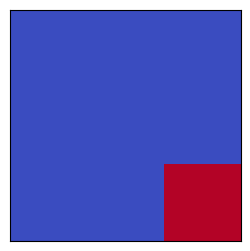

In [39]:
from matplotlib.animation import FuncAnimation
# def plot_grid(learning_history):

grids = []

goal = learning_history[0].index("G")

for maze in learning_history:
    player = learning_history[-1].index("P")
    grid = np.zeros((3, 3))
    x, y = divmod(player, 3)  
    gx, gy = divmod(goal, 3)

    grid[x, y] = 1  # Posizione del giocatore
    grid[gx, gy] = 2  # Posizione del goal
    grids.append(grid.copy())

fig, ax = plt.subplots(figsize=(3, 3))  
ax.imshow(grids[-1], cmap="coolwarm", origin="upper")
ax.set_xticks([]), ax.set_yticks([])
animated_plot, = ax.plot([],[])
print(animated_plot)
plt.show()

def update_data(frame):
    animated_plot.set_data(grid[frame])
    return animated_plot

animation = FuncAnimation(
    fig=fig,
    func=update_data,
    frames=len(learning_history),
    interval=500
)


In [45]:
import pygame
import time

# Initialize pygame
pygame.init()

# Constants
N = 3
CELL_SIZE = 100
WINDOW_SIZE = (N * CELL_SIZE, N * CELL_SIZE)
screen = pygame.display.set_mode(WINDOW_SIZE)
pygame.display.set_caption("Maze Evolution")

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

def draw_maze(maze, N):
    screen.fill(WHITE)
    for i in range(N):
        for j in range(N):
            if maze[i * N + j] == 'X':
                pygame.draw.rect(screen, BLACK, (j * CELL_SIZE, i * CELL_SIZE, CELL_SIZE, CELL_SIZE))
    pygame.display.flip()

# Example usage
maze = [' '] * (N * N)  # Initialize an empty maze

# Simulate maze evolution
for step in range(5):
    draw_maze(maze, N)  # Draw the current state of the maze
    time.sleep(1)  # Simulate time passing
    maze[step] = 'X'  # Update the maze

# Quit pygame
pygame.quit()

In [1]:
import pygame
import time

# Initialize pygame
pygame.init()

# Constants
N = 3
CELL_SIZE = 100
MAZE_WIDTH = N * CELL_SIZE
DESCRIPTION_WIDTH = 400
WINDOW_SIZE = (MAZE_WIDTH + DESCRIPTION_WIDTH, N * CELL_SIZE)
screen = pygame.display.set_mode(WINDOW_SIZE)
pygame.display.set_caption("Maze Evolution with Description")

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (200, 200, 200)

# Fonts
size = 20 
font = pygame.font.Font(None, size)

def draw_maze(maze, N, description):
    # Clear the screen
    screen.fill(WHITE)

    # Draw the maze
    for i in range(N):
        for j in range(N):
            if maze[i * N + j] == 'X':
                pygame.draw.rect(screen, BLACK, (j * CELL_SIZE, i * CELL_SIZE, CELL_SIZE, CELL_SIZE))
            # Draw grid lines
            pygame.draw.rect(screen, GRAY, (j * CELL_SIZE, i * CELL_SIZE, CELL_SIZE, CELL_SIZE), 1)

    # Draw the description
    description_x = MAZE_WIDTH + 20  # Start description 20 pixels to the right of the maze
    description_y = 20
    for line in description:
        text_surface = font.render(line, True, BLACK)
        screen.blit(text_surface, (description_x, description_y))
        description_y +=  size + 4 # Move down for the next line

    # Update the display
    pygame.display.flip()

# Example usage
maze = [' '] * (N * N)  # Initialize an empty maze
description = []  # List to store description lines

# Simulate maze evolution
for step in range(5):
    # Update the maze
    maze[step] = 'X'

    # Update the description
    i = step // N  # Row index
    j = step % N   # Column index
    description.append(f"From ({i}, {j}) to ({i}, {j + 1})")

    # Draw the maze and description
    draw_maze(maze, N, description)
    time.sleep(1)  # Simulate time passing

# Quit pygame
pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
